# Recurrent Neural Networks For Enhancer Activity Classification

**Authorship:**
Adam Klie, *10/24/2021*
***
**Description:**
Notebook to train preliminary Recurrent Neural Network (CNN) classifiers for predicting enhancer activity
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

In [30]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [31]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

In [32]:
# Check for GPU
import torch

print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))

Using a GPU? True
Device number [0-7]: 0


# Define parameters of the notebook

In [33]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "ohe-seq"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
TRAIN = False
SPLIT = 0.9
SUBSET = False
HYPERPARAM = "baseline"
ARCHITECTURE = "EUGENE_biLSTM"
from EUGENE_biLSTM import EUGENE_biLSTM

# Load data

In [7]:
X_train = np.load('../data/{0}/{1}/{2}_X-train-{3}_{4}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))
X_test = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
X_train_rev = np.load('../data/{0}/{1}/{2}_X-train-{3}_rev-{4}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, SPLIT, FEATURES))
X_test_rev = np.load('../data/{0}/{1}/{2}_X-test-{3}_rev-{4}.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
y_train = np.loadtxt('../data/{0}/{1}/{2}_y-train-{3}_{1}.txt'.format(DATASET.replace("-", "_"), LABELS, PREPROCESS, SPLIT), dtype=int)
y_test = np.loadtxt('../data/{0}/{1}/{2}_y-test-{3}_{1}.txt'.format(DATASET.replace("-", "_"), LABELS, PREPROCESS, round(1-SPLIT, 1)), dtype=int)

In [9]:
X_train.shape, X_train_rev.shape, y_train.shape, X_test.shape, X_test_rev.shape, y_test.shape

((272642, 4, 66),
 (272642, 4, 66),
 (272642,),
 (30294, 4, 66),
 (30294, 4, 66),
 (30294,))

# Train and test an RNN classifier

## **RNN training**

In [116]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class EUGENE_biLSTM_test(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, num_classes=1, dropout=0.5):
        super(EUGENE_biLSTM_test, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.reverse_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x, x_rev):
        
        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out_reverse, _ = self.reverse_lstm(x_rev)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = torch.cat((out, out_reverse), dim=2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [117]:
# Instantiate model and move to gpu if available
eugene = EUGENE_biLSTM_test(66, num_layers=5, dropout=0.1)
#eugene.apply(project_utils.init_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on :", device)
eugene.to(device)

Executing the model on : cuda


EUGENE_biLSTM_test(
  (lstm): LSTM(66, 32, num_layers=5, batch_first=True)
  (reverse_lstm): LSTM(66, 32, num_layers=5, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [118]:
# Grab some seqs and outputs to test out on
indexes = np.random.choice(len(X_train), size=5)
random_seqs = torch.from_numpy(X_train[indexes, :, :]).float().to(device)
random_rev_seqs = torch.from_numpy(X_train_rev[indexes, :, :]).float().to(device)
outputs = eugene(random_seqs, random_rev_seqs).squeeze(dim=1)
random_labels = torch.from_numpy(y_train[indexes]).to(device)
print(outputs)
print(random_labels)

tensor([-0.1180, -0.1179, -0.1180, -0.1179, -0.1180], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0, 0, 0, 0, 0], device='cuda:0')


In [119]:
from torch.utils.data import TensorDataset, DataLoader

In [120]:
# Build Datasets objects from arrays
#train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_dataset = TensorDataset(torch.from_numpy(np.stack([X_train, X_train_rev], axis=3)), torch.from_numpy(y_train))
#val_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
val_dataset = TensorDataset(torch.from_numpy(np.stack([X_test, X_test_rev], axis=3)), torch.from_numpy(y_test))

In [121]:
# Build Loaders from the Datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

In [122]:
# Check dims of loaders for correctness
print("Dimensions of training set: {} x {}".format(len(train_loader.dataset), train_loader.dataset[0][0].shape))
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset), val_loader.dataset[0][0].shape))

Dimensions of training set: 272642 x torch.Size([4, 66, 2])
Dimensions of validation set: 30294 x torch.Size([4, 66, 2])


In [123]:
from livelossplot import PlotLosses

In [124]:
# Current livelossplot compatible training script
def train_model(model, criterion, optimizer, num_epoch):
    liveloss = PlotLosses()
    loss_history, acc_history = {}, {}
    for epoch in range(num_epoch):
        logs = {}
        for phase in ['validation', 'train']:
            if phase == 'train':
                if epoch < 150:
                    model.train()
                else:
                    model.eval()
            else:
                model.eval()
            
            running_loss = 0.0
            running_acc = 0.0
            for inputs, targets in dataloaders[phase]:
                #inputs = inputs.to(device)
                input_forward = inputs[:, :, :, 0].to(device)
                input_reverse = inputs[:, :, :, 1].to(device)
                #outputs = model(inputs.float())
                outputs = model(input_forward.float(), input_reverse.float())
                targets = targets.unsqueeze(dim=1).to(device)
                loss = criterion(outputs, targets.float())
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()                
                    optimizer.step()            
                
                running_loss += loss.item()
                running_acc += project_utils.accuracy(outputs, targets)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)
                
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'acc'] = epoch_acc
            
            loss_history.setdefault(phase, []).append(epoch_loss)
            acc_history.setdefault(phase, []).append(epoch_acc)
            
        liveloss.update(logs)
        liveloss.send()
    return loss_history, acc_history, liveloss

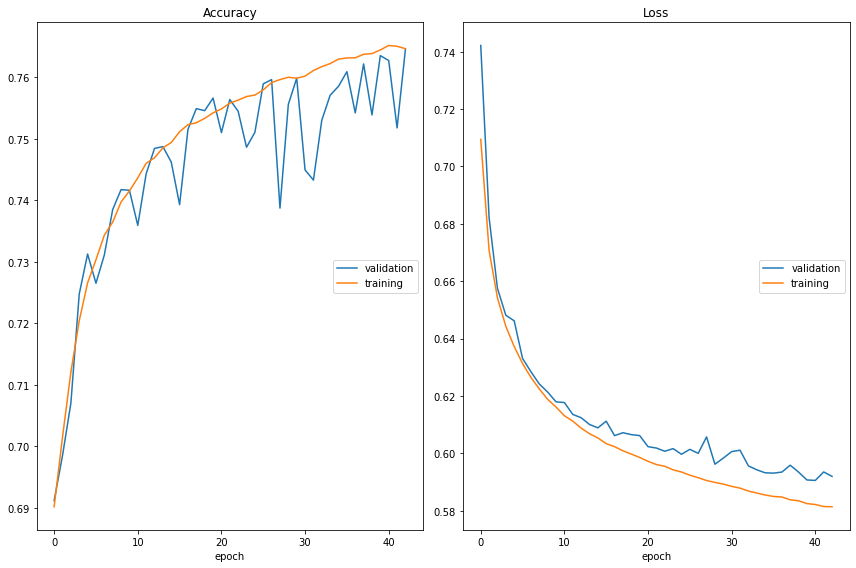

Accuracy
	validation       	 (min:    0.691, max:    0.765, cur:    0.765)
	training         	 (min:    0.690, max:    0.765, cur:    0.765)
Loss
	validation       	 (min:    0.591, max:    0.742, cur:    0.592)
	training         	 (min:    0.581, max:    0.709, cur:    0.581)


In [ ]:
### Train the model
dataloaders = {"train": train_loader, "validation": val_loader}
optimizer = torch.optim.Adam(eugene.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor(1.3))
loss_history, acc_history, _ = train_model(eugene, criterion, optimizer, 50)

#### <u> **Save final model** </u> 

In [33]:
torch.save(eugene.state_dict(), "{}_{}_{}-clf_{}.pt".format(PREPROCESS, FEATURES, ARCHITECTURE, HYPERPARAM))

## **RNN testing**

In [36]:
from EUGENE_RNN import EUGENE_RNN
test_eugene = EUGENE_RNN(66)
test_eugene.load_state_dict(torch.load("{}_{}_{}-clf_{}.pt".format(PREPROCESS, FEATURES, ARCHITECTURE, HYPERPARAM), map_location=torch.device('cpu')))
test_eugene.eval()

EUGENE_RNN(
  (lstm): LSTM(66, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [37]:
y_tr_outputs = test_eugene(torch.tensor(X_train).float()).detach()
y_tr_probs = torch.sigmoid(y_tr_outputs).detach().numpy()
y_tr_preds = np.round(y_tr_probs)

In [38]:
y_outputs = test_eugene(torch.tensor(X_test).float()).detach()
y_probs = torch.sigmoid(y_outputs).detach().numpy()
y_preds = np.round(y_probs)

### <u>**Confusion matrices** </u>

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
np.unique(y_tr_preds, return_counts=True), np.unique(y_preds, return_counts=True)

((array([0., 1.], dtype=float32), array([206191,  66451])),
 (array([0., 1.], dtype=float32), array([22891,  7403])))

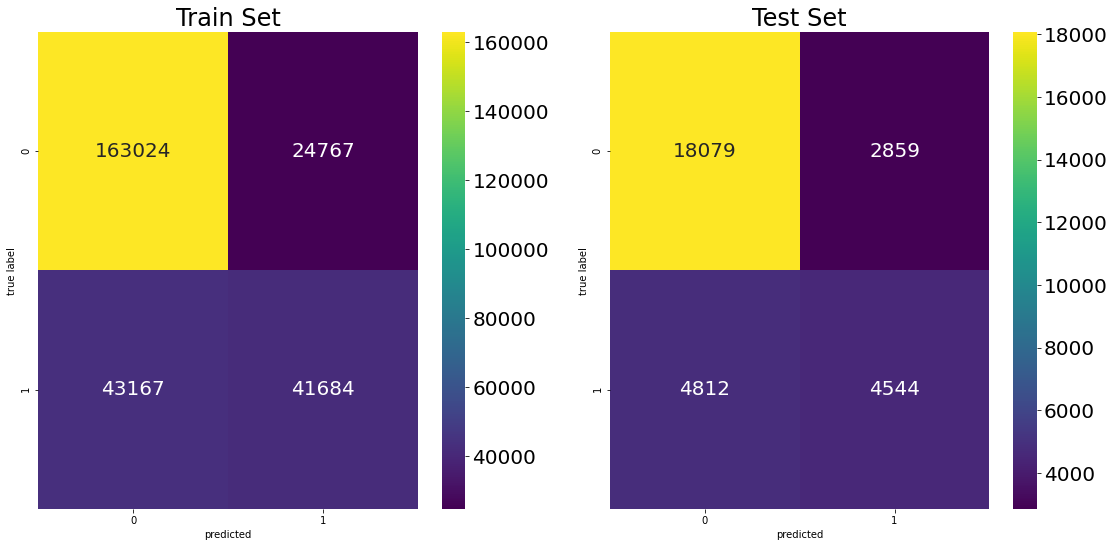

In [41]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

rc = {'font.size': 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')
    
    plt.tight_layout()

### <u> **Accuracies** </u>

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
train_acc, test_acc = accuracy_score(y_true=y_train, y_pred=y_tr_preds), accuracy_score(y_true=y_test, y_pred=y_preds)

In [44]:
print("Train Acc", "Test Acc", sep='\t')
print("{:.4}\t{:.4f}".format(train_acc, test_acc))

Train Acc	Test Acc
0.7508	0.7468


### <u> **F-scores** </u>

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [47]:
def fbeta_score(pr, rec, beta):
    return (1+(beta**2))*((pr*rec)/(((beta**2)*pr)+rec))

In [48]:
train_prec, test_prec = precision_score(y_true=y_train, y_pred=y_tr_preds), precision_score(y_true=y_test, y_pred=y_preds)

In [49]:
train_recall, test_recall = recall_score(y_true=y_train, y_pred=y_tr_preds), recall_score(y_true=y_test, y_pred=y_preds)

In [50]:
train_f1, test_f1 = f1_score(y_true=y_train, y_pred=y_tr_preds), f1_score(y_true=y_test, y_pred=y_preds)

In [51]:
fbeta_tr_scores = []
fbeta_scores = []
for b in [0.1, 0.5, 1, 2, 10]:
    fbeta_tr_scores.append(fbeta_score(train_prec, train_recall, b))
    fbeta_scores.append(fbeta_score(test_prec, test_recall, b))

In [52]:
print("Metric", "Train", "Test", sep='\t')
print("{:s}\t{:.4f}\t{:.4f}".format("Precision", train_prec, test_prec))
print("{:s}\t{:.4f}\t{:.4f}".format("Recall", train_recall, test_recall))
#print("{:s}\t{:.4f}\t{:.4f}".format("F1-Score", train_f1, test_f1))
for i, b in enumerate([0.1, 0.5, 1, 2, 10]):
    print("F{:s}-Score\t{:.4f}\t{:.4f}".format(str(b), fbeta_tr_scores[i], fbeta_scores[i])) 

Metric	Train	Test
Precision	0.6273	0.6138
Recall	0.4913	0.4857
F0.1-Score	0.6256	0.6122
F0.5-Score	0.5944	0.5830
F1-Score	0.5510	0.5423
F2-Score	0.5135	0.5068
F10-Score	0.4923	0.4867


### <u> **Precision-recall** </u>

In [53]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [54]:
precs_tr, recs_tr, threshs_tr = precision_recall_curve(y_true=y_train, probas_pred=y_tr_probs)
avg_prec_tr = average_precision_score(y_true=y_train, y_score=y_tr_probs)

In [55]:
precs, recs, threshs = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
avg_prec = average_precision_score(y_true=y_test, y_score=y_probs)

In [56]:
avg_prec_tr, avg_prec

(0.6249521313438444, 0.6118285926811063)

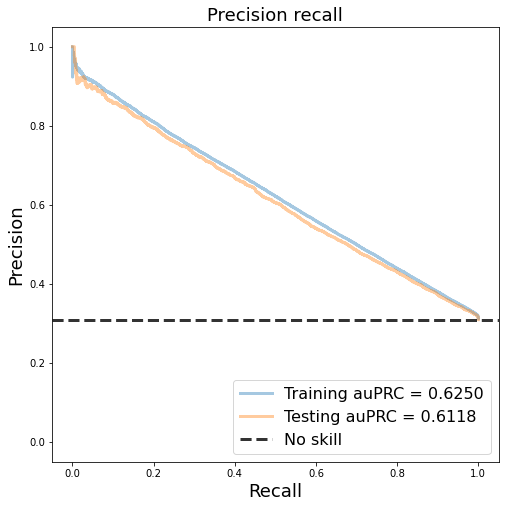

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.step(recs_tr, precs_tr, where='post', lw=3, alpha=0.4, label='Training auPRC = %0.4f' % (avg_prec_tr))
ax.step(recs, precs, where='post', lw=3, alpha=0.4, label='Testing auPRC = %0.4f' % (avg_prec))
ax.axhline(len(y_test[y_test==1])/len(y_test), linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Recall', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
ax.set_title('Precision recall', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

### <u> **Reciever operating characteristic** </u>

In [58]:
from sklearn.metrics import roc_curve, auc

In [59]:
fprs_tr, tprs_tr, threshs_tr = roc_curve(y_true=y_train, y_score=y_tr_probs)
roc_auc_tr = auc(fprs_tr, tprs_tr)

In [60]:
fprs, tprs, threshs = roc_curve(y_true=y_test, y_score=y_probs)
roc_auc = auc(fprs, tprs)

In [61]:
roc_auc_tr, roc_auc

(0.7600349535243427, 0.7522449905135343)

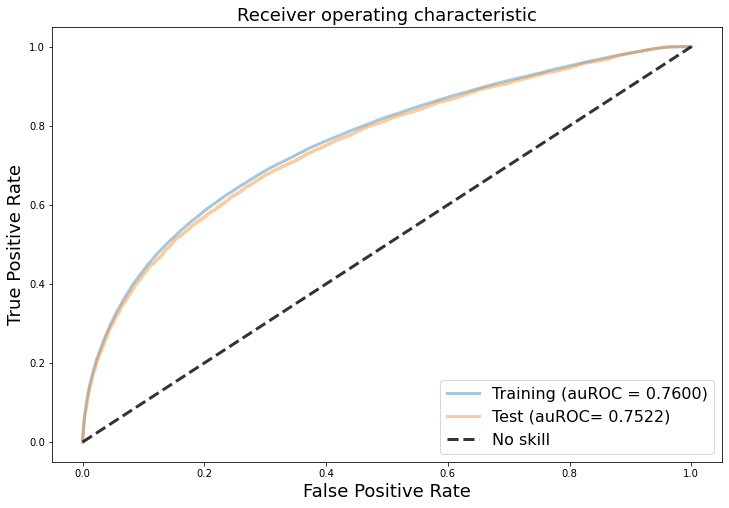

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(fprs_tr, tprs_tr, lw=3, alpha=0.4, label='Training (auROC = %0.4f)' % (roc_auc_tr))
ax.plot(fprs, tprs, lw=3, alpha=0.4, label='Test (auROC= %0.4f)' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

# Scratch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=len(X_test))
eugene.to("cpu")
for X_train_tensor, y_train_tensor in val_loader:
    pass
y_tr_outputs = eugene(X_train_tensor.float()).detach()
y_tr_probs = torch.sigmoid(y_tr_outputs).detach().numpy()
y_tr_preds = np.round(y_tr_probs)

In [91]:
val_loader = DataLoader(val_dataset, batch_size=len(X_test))
eugene.to("cpu")
for X_test_tensor, y_test_tensor in val_loader:
    pass
y_outputs = eugene(X_test_tensor.float()).detach()
y_probs = torch.sigmoid(y_outputs).detach().numpy()
y_preds = np.round(y_probs)

### <u>**Confusion matrices** </u>

In [86]:
from sklearn.metrics import confusion_matrix

In [87]:
np.unique(y_tr_preds, return_counts=True)
np.unique(y_preds, return_counts=True)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

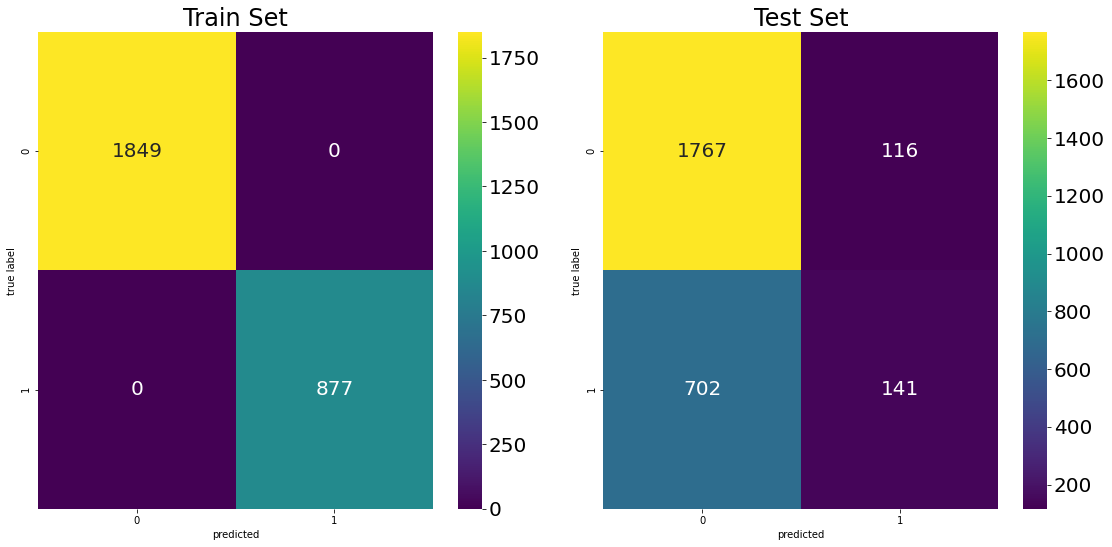

In [142]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

rc = {'font.size': 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')
    
    plt.tight_layout()

### <u> **Accuracies** </u>

In [143]:
from sklearn.metrics import accuracy_score

In [144]:
train_acc, test_acc = accuracy_score(y_true=y_train, y_pred=y_tr_preds), accuracy_score(y_true=y_test, y_pred=y_preds)

In [145]:
print("Train Acc", "Test Acc", sep='\t')
print("{:.4}\t{:.4f}".format(train_acc, test_acc))

Train Acc	Test Acc
1.0	0.6999


### <u> **F-scores** </u>

In [146]:
IFrame('https://en.wikipedia.org/wiki/F-score', width=800, height=400)

In [147]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [148]:
def fbeta_score(pr, rec, beta):
    return (1+(beta**2))*((pr*rec)/(((beta**2)*pr)+rec))

In [149]:
train_prec, test_prec = precision_score(y_true=y_train, y_pred=y_tr_preds), precision_score(y_true=y_test, y_pred=y_preds)

In [150]:
train_recall, test_recall = recall_score(y_true=y_train, y_pred=y_tr_preds), recall_score(y_true=y_test, y_pred=y_preds)

In [151]:
train_f1, test_f1 = f1_score(y_true=y_train, y_pred=y_tr_preds), f1_score(y_true=y_test, y_pred=y_preds)

In [152]:
fbeta_tr_scores = []
fbeta_scores = []
for b in [0.1, 0.5, 1, 2, 10]:
    fbeta_tr_scores.append(fbeta_score(train_prec, train_recall, b))
    fbeta_scores.append(fbeta_score(test_prec, test_recall, b))

In [153]:
print("Metric", "Train", "Test", sep='\t')
print("{:s}\t{:.4f}\t{:.4f}".format("Precision", train_prec, test_prec))
print("{:s}\t{:.4f}\t{:.4f}".format("Recall", train_recall, test_recall))
#print("{:s}\t{:.4f}\t{:.4f}".format("F1-Score", train_f1, test_f1))
for i, b in enumerate([0.1, 0.5, 1, 2, 10]):
    print("F{:s}-Score\t{:.4f}\t{:.4f}".format(str(b), fbeta_tr_scores[i], fbeta_scores[i])) 

Metric	Train	Test
Precision	1.0000	0.5486
Recall	1.0000	0.1673
F0.1-Score	1.0000	0.5365
F0.5-Score	1.0000	0.3768
F1-Score	1.0000	0.2564
F2-Score	1.0000	0.1943
F10-Score	1.0000	0.1684


### <u> **Precision-recall** </u>

In [132]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [133]:
precs_tr, recs_tr, threshs_tr = precision_recall_curve(y_true=y_train, probas_pred=y_tr_probs)
avg_prec_tr = average_precision_score(y_true=y_train, y_score=y_tr_probs)

In [134]:
precs, recs, threshs = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
avg_prec = average_precision_score(y_true=y_test, y_score=y_probs)

In [135]:
avg_prec_tr, avg_prec

(1.0, 0.5936992585369412)

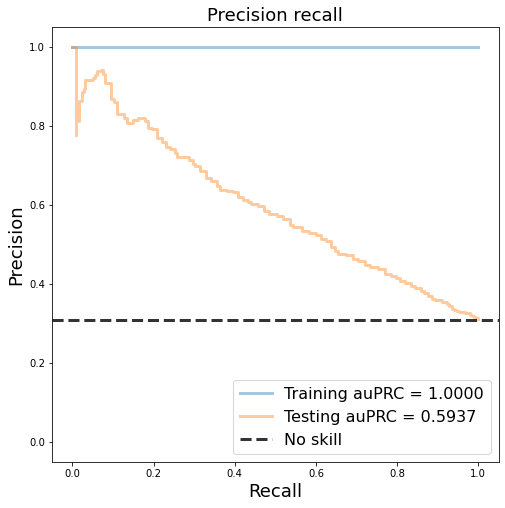

In [136]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.step(recs_tr, precs_tr, where='post', lw=3, alpha=0.4, label='Training auPRC = %0.4f' % (avg_prec_tr))
ax.step(recs, precs, where='post', lw=3, alpha=0.4, label='Testing auPRC = %0.4f' % (avg_prec))
ax.axhline(len(y_test[y_test==1])/len(y_test), linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Recall', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
ax.set_title('Precision recall', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

### <u> **Reciever operating characteristic** </u>

In [105]:
from sklearn.metrics import roc_curve, auc

In [106]:
fprs_tr, tprs_tr, threshs_tr = roc_curve(y_true=y_train, y_score=y_tr_probs)
roc_auc_tr = auc(fprs_tr, tprs_tr)

In [107]:
fprs, tprs, threshs = roc_curve(y_true=y_test, y_score=y_probs)
roc_auc = auc(fprs, tprs)

In [108]:
roc_auc_tr, roc_auc

(0.9022159347744443, 0.6612879551005468)

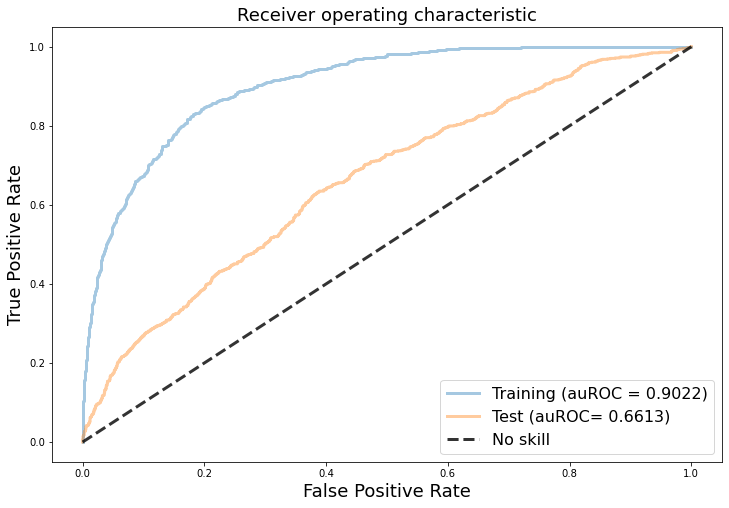

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(fprs_tr, tprs_tr, lw=3, alpha=0.4, label='Training (auROC = %0.4f)' % (roc_auc_tr))
ax.plot(fprs, tprs, lw=3, alpha=0.4, label='Test (auROC= %0.4f)' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

## Save the classifier

In [ ]:
import pickle

In [219]:
#file = '../data/2021_OLS_Library/RF/0.18-0.4_mixed-encoding_RF-clf_randomCV.pickle'
#file = '0.18-0.4_mixed_RF-clf.pickle'
#file = '0.18-0.4_mixed_2.0_RF-clf.pickle'
file = '0.18-0.4_mixed_RF-clf_hyperopt.pickle'

In [220]:
pickle.dump(clf, open(file, 'wb'))

In [84]:
test_load = pickle.load(open(file, 'rb'))
np.unique(test_load.predict(X_test), return_counts=True)

(array([0, 1]), array([24479,  5815]))